**Name:** Rahul Kumar

**Student ID:** rxk190002

***

# Results
- Models used with hyperparameters - KNN regressor, linear regression, linear regression with SGD, Ridge, Lasso, ElasticNet,             Polynomial regression, SVM simple and with kernels (rbf, poly, and sigmoid kernel), Decision Tree regression, Two models         with Pasting, Two models with Bagging, Random Forest, Ada Boost (with decision tree, Gradient Boost, Extra-Trees,               XGBoost, Voting Regressor to combine results of top 5 models, Voting Regressor to combine results of models with least           correlation, Stacking Regressor to combine results of top 5 models, Stacking Regressor to combine results of models with             least correlation


- Best Model parameters - 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8       (XGBoost)
- Mean Cross validation score of Best model - 0.8981992683459357 (XGBoost)
- Test score of best model - 0.8776048030903614 (XGBoost)
- Train score of best model - 0.979396879296572 (XGBoost)
- r2_score of best model - 0.8776048030903614 (XGBoost)

## Data PreProcessing

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

### Load Datasets

In [2]:
# load dataset
# your code here
data = pd.read_csv(r"C:\Users\Rahul\Downloads\houseprice.csv")


### Types of variables



In [3]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


#### Find categorical variables

In [4]:
# find categorical variables- hint data type = 'O'

categorical = [var for var in data.columns if data[var].dtype=='O']

print(f'There are {len(categorical)} categorical variables')

There are 43 categorical variables


#### Find temporal variables

In [5]:
# make a list of the numerical variables first= Hint data type != O
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information= Hint variable namme has Yr or 
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

#### Find discrete variables

To identify discrete variables- numerical variables with less than 20 unique values 

In [6]:
# let's visualise the values of the discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print(f'There are {len(discrete)} discrete variables')

There are 14 discrete variables


#### Continuous variables

In [7]:
# find continuous variables- hint numerical variables not in discrete and  year_years 
# Also remove the Id variable and the target variable SalePrice
# which are both also numerical

continuous = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 38 numerical and continuous variables


### Separate train and test set

In [8]:
# Let's separate into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Craete New Variables

Replace 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt  with time elapsed since YrSold
So YearBuilt = YrSold-YearBuilt. 

Similarly transform 'YearRemodAdd', 'GarageYrBlt.
After making transformation drop YrSold

In [9]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [10]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [11]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [12]:
year_vars.remove('YrSold')

In [13]:
# capture the column names for use later in the notebook
final_columns = X_train.columns
final_columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

### Feature Engineering Pipeline

In [14]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [15]:
# import relevant modules for feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from feature_engine import missing_data_imputers as mdi
from feature_engine import categorical_encoders as ce
from feature_engine.variable_transformers import YeoJohnsonTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.discretisers import DecisionTreeDiscretiser

In [16]:
house_preprocess = Pipeline([
    
    # missing data imputation 
    ('missing_ind', mdi.AddNaNBinaryImputer(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_cat', mdi.CategoricalVariableImputer(variables=categorical)),

    # categorical encoding 
     ('rare_label_enc', ce.RareLabelCategoricalEncoder(
         tol=0.01,n_categories=6, variables=categorical+discrete)),
    ('categorical_enc', ce.MeanCategoricalEncoder(variables = categorical + discrete)),
     
    # Transforming Numerical Variables
    ('yjt', YeoJohnsonTransformer(variables = ['LotFrontage','MasVnrArea', 'GarageYrBlt'])),

    
    # discretisation and encoding
    ('treeDisc',  DecisionTreeDiscretiser(cv=2, scoring='neg_mean_squared_error',
                                   regression=True,
                                   param_grid={'max_depth': [1,2,3,4,5,6]})),

    # feature Scaling
    ('scaler', StandardScaler()),
    
    

])

In [17]:
house_preprocess.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('missing_ind',
                 AddNaNBinaryImputer(variables=['LotFrontage', 'MasVnrArea',
                                                'GarageYrBlt'])),
                ('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'MasVnrArea',
                                              'GarageYrBlt'])),
                ('imputer_cat',
                 CategoricalVariableImputer(variables=['MSZoning', 'Street',
                                                       'Alley', 'LotShape',
                                                       'LandContour',
                                                       'Utilities', '...
                                                    'Utilities', 'LotConfig',
                                                    'LandSlope', 'Neighborhood',
                                                    'Condition1', 'Condition2',
    

In [18]:
# Apply Transformations
X_train=house_preprocess.transform(X_train)
X_test=house_preprocess.transform(X_test)

## <span class="mark">DO NOT CHANGE STEPS BEFORE THIS POINT</span>

## Regression Models- Tune different models one by one

In [19]:
# Train a linear regression model, report the coefficients and model performance 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

lr = LinearRegression().fit(X_train, y_train)
cv_scores = cross_val_score(lr, X_train, y_train)

y_pred_linear = lr.predict(X_test)

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()))

# Print Co-efficients
print("lr.coef_:", lr.coef_)
print("lr.intercept_:", lr.intercept_)

# Check test data set performance
print("LR Performance Test: ", lr.score(X_train,y_train))
print('r2_score: ', r2_score(y_test,y_pred_linear))

Mean Cross-validation scores: -1.2531233677405604e+21
lr.coef_: [ 8.85927525e+02  9.63821950e+02  1.55093914e+03  2.38123720e+03
  1.54867121e+03  3.94643841e+02  5.73339946e+02  1.32077662e+03
  1.55946597e+03  2.25919167e+03  1.27504991e+03  1.12929618e+04
  1.31777294e+03  2.04524613e+03  1.21008674e+03 -9.02846098e+02
  1.58511847e+04 -9.82124059e+01 -5.41455300e+03  3.94119726e+03
  3.73336495e+02 -1.17351708e+03  3.44591704e+03 -2.45906679e+03
 -8.92244713e+02  2.64169300e+02  2.55034152e+03  5.77675879e+02
  1.02547905e+01  2.43524833e+03  5.95239944e+02  3.56353271e+03
  1.33859388e+03  5.57728195e+03 -1.43383745e+03  2.11644961e+03
 -2.80153401e+02  7.89568089e+03  2.44320365e+02  1.63894561e+03
  1.03758613e+03 -7.92545735e+02  1.21578274e+04  1.11657512e+04
  4.20710717e+03  5.60685225e+03  2.72048329e+03 -1.21950180e+03
  4.38283844e+03  5.39795630e+03  5.97516292e+02  2.94689148e+03
  3.71875504e+03  3.03060751e+03  3.03991793e+03  6.48653394e+02
  1.78422356e+03 -2.195439

In [20]:
# Train a KNN regressor model

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_param_grid = {'n_neighbors' : range(1,20), 'p': [1,2], 'weights': ['distance','uniform']}

grid_knn = GridSearchCV(estimator = knn_reg, param_grid = knn_param_grid, cv=5, return_train_score=True, n_jobs= -1)
grid_knn.fit(X_train, y_train)

y_pred_knn = grid_knn.predict(X_test)

best_parameters_knn=grid_knn.best_params_

print('train score: ', grid_knn.score(X_train, y_train))

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_))
print()

#find best parameters
print('KNN parameters: ', grid_knn.best_params_)

# Check test data set performance
print("KNN Test Performance: ", grid_knn.score(X_test,y_test))
print('r2_score: ', r2_score(y_test,y_pred_knn))

train score:  0.9999955968722103
Best Mean Cross-validation score: 0.84

KNN parameters:  {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
KNN Test Performance:  0.8017952424805856
r2_score:  0.8017952424805856


In [21]:
# Train a Ridge regression model, report the coefficients, the best parameters, and model performance 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[0.001, 0.01, 0.1, 1, 10, 100, 200] }

grid_ridge = GridSearchCV(ridge, param_ridge, cv=6, return_train_score = True)
grid_ridge.fit(X_train, y_train)

y_pred_ridge = grid_ridge.predict(X_test)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_ridge.best_score_))

print('train score: ', grid_ridge.score(X_train, y_train))

#find best parameters
print('Ridge parameters: ', grid_ridge.best_params_)

# print co-eff

print("Ridge.coef_:", grid_ridge.best_estimator_.coef_)
print("Ridge.intercept_:", grid_ridge.best_estimator_.intercept_)

# Check test data set performance

print("Ridge Test Performance: ", grid_ridge.score(X_test,y_test))
print('r2_score: ', r2_score(y_test,y_pred_ridge))

Best Mean Cross-validation score: 0.89
train score:  0.9103295889443213
Ridge parameters:  {'alpha': 100}
Ridge.coef_: [ 6.21659729e+02  1.17460178e+03  1.42941553e+03  2.64606835e+03
  1.51146267e+03  2.62791603e+02  6.67979067e+02  1.18774714e+03
  1.42260925e+03  2.24214684e+03  1.25368077e+03  9.92739531e+03
  1.23361742e+03  1.99010230e+03  1.20327177e+03 -6.63081364e+02
  1.30900812e+04 -4.66276510e+02 -2.83583594e+03  3.23156417e+03
  6.84148916e+02 -6.10003713e+02  1.78250368e+03 -1.24106895e+03
 -8.16647095e+02  8.17430994e+02  3.38262729e+03  6.89414122e+02
 -2.93079656e+02  2.71590898e+03  4.54540556e+02  3.45654634e+03
  1.37124639e+03  5.85727188e+03 -1.21460614e+03  1.83762570e+03
 -2.50335442e+02  7.78490680e+03  1.59374113e+02  1.42274787e+03
  1.23479897e+03 -5.43667577e+02  1.07696364e+04  1.01767254e+04
  3.73457884e+03  6.25609926e+03  2.54341163e+03 -1.10107201e+03
  3.81888633e+03  4.50746959e+03  8.23531957e+02  2.86618489e+03
  4.19642055e+03  3.72923474e+03  2.

In [22]:
# Train a Lasso regression model, report the coefficients, the best parameters, and model performance 

# YOUR CODE HERE

from sklearn.linear_model import Lasso
lasso = Lasso(random_state=0)

#define a list of parameters
param_lasso = {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 200] }

grid_lasso = GridSearchCV(lasso, param_lasso, cv=6, return_train_score = True)
grid_lasso.fit(X_train, y_train)

y_pred_lasso = grid_lasso.predict(X_test)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_lasso.best_score_))
print('train score: ', grid_lasso.score(X_train, y_train))

#find best parameters
print('Lasso parameters: ', grid_lasso.best_params_)

# print co-eff

print("Lasso.coef_:", grid_lasso.best_estimator_.coef_)
print("Lasso.intercept_:", grid_lasso.best_estimator_.intercept_)

# Check test data set performance
print("Lasso Test Performance: ", grid_lasso.score(X_test,y_test))

print('r2_score: ', r2_score(y_test,y_pred_lasso))

Best Mean Cross-validation score: 0.89
train score:  0.9107634746095196
Lasso parameters:  {'alpha': 200}
Lasso.coef_: [ 3.25231511e+02  9.83524218e+02  1.24353514e+03  2.50798876e+03
  1.39998324e+03  8.24559857e+01  4.45556752e+02  1.02321817e+03
  1.22961417e+03  2.13853082e+03  1.17279944e+03  1.11325473e+04
  1.03709105e+03  1.95240546e+03  1.16723234e+03 -4.39635094e+02
  1.58656121e+04 -2.15084519e+02 -4.06271077e+03  3.25452562e+03
  2.02869288e+02 -5.45110710e+02  6.55670929e+02 -0.00000000e+00
 -2.87631837e+02  0.00000000e+00  2.31273936e+03  5.49599860e+02
 -0.00000000e+00  1.90975226e+03  1.70083664e+02  3.36678296e+03
  7.83913056e+02  5.94675890e+03 -9.75945765e+02  1.66412198e+03
 -1.09234292e+02  7.78556001e+03  1.05093159e+01  1.16384277e+03
  1.22135452e+03 -1.18989069e+02  1.22803546e+04  1.14020560e+04
  3.80227138e+03  5.89250430e+03  2.85576377e+03 -1.10140773e+03
  3.58192701e+03  4.85099861e+03  5.86007790e+02  2.77780052e+03
  3.81014560e+03  3.01362902e+03  2.

In [23]:
# Train a ElasticNet regression model

from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(max_iter=10000, tol=0.6)

#define a list of parameters
param_elasticnet = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio' :[0.2,0.4,0.6,0.8]}

grid_elasticnet = GridSearchCV(elasticnet , param_elasticnet, cv=5, return_train_score = True)
grid_elasticnet.fit(X_train, y_train)

y_pred_elasticnet = grid_elasticnet.predict(X_test)

grid_elasticnet_train_score = grid_elasticnet.score(X_train, y_train)
grid_elasticnet_test_score = grid_elasticnet.score(X_test, y_test)

print('Training set score: ', grid_elasticnet_train_score)
print('Test score: ', grid_elasticnet_test_score)

#find best parameters
print('Best parameters: ', grid_elasticnet.best_params_)
print('Best cross-validation score:', grid_elasticnet.best_score_)
print('r2_score: ', r2_score(y_test,y_pred_elasticnet))

Training set score:  0.8804293481051425
Test score:  0.8303971782903924
Best parameters:  {'alpha': 1, 'l1_ratio': 0.2}
Best cross-validation score: 0.8625901078702587
r2_score:  0.8303971782903924


In [24]:
# Train a linear regression with SGD model

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

# create pipeline
reg_sgd_pipe = Pipeline([

    # feature Scaling
    ('scaler', MinMaxScaler()),
    # regression
    ('sgd_reg', SGDRegressor(max_iter=10000, tol = 1e-6))
])

param_sgd = {'sgd_reg__eta0':[0.01, 0.05, 0.1 ,0.5]}
grid_sgd = GridSearchCV(reg_sgd_pipe, param_sgd,cv=5, n_jobs=-1, return_train_score = True)
grid_sgd.fit(X_train, y_train)

y_pred_sgd = grid_sgd.predict(X_test)

grid_sgd_train_score = grid_sgd.score(X_train, y_train)
grid_sgd_test_score = grid_sgd.score(X_test, y_test)

print('Training set score: ', grid_sgd_train_score)
print('Test score: ', grid_sgd_test_score)


print("Best parameters: {}".format(grid_sgd.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_sgd.best_score_))
print('r2_score: ', r2_score(y_test,y_pred_sgd))

Training set score:  0.9047955550712964
Test score:  0.8625098420990859
Best parameters: {'sgd_reg__eta0': 0.05}
Best cross-validation score: 0.88
r2_score:  0.8625098420990859


In [25]:
#apply polynomial regression in pipeline
from sklearn.preprocessing  import PolynomialFeatures
pipe_poly=Pipeline([ 
    ('polynomialfeatures', PolynomialFeatures()),
    ('scaler',MinMaxScaler()),
    ('ridge', Ridge())
    
])

#define a list of parameters
param_poly = {'polynomialfeatures__degree':range(1,3)}

#apply polynomial regression in pipeline
grid_poly = GridSearchCV(pipe_poly, param_poly,cv=5, n_jobs=-1, return_train_score = True)
grid_poly.fit(X_train, y_train)

y_pred_poly=grid_poly.predict(X_test)

print('train score: ', grid_poly.score(X_train, y_train))

# Mean Cross Validation Score
#print("Cross Validation training results", grid_poly.cv_results_['best_train_score'])
#print("Cross Validation testing results", grid_poly.cv_results_['best_test_score'])

#find best parameters
print('Poly parameters: ', grid_poly.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_poly.best_score_))

# print the coefficients
print('Poly features: ', grid_poly.best_estimator_.named_steps['polynomialfeatures'].n_output_features_)
print('Coefficients: ', grid_poly.best_estimator_.named_steps['ridge'].coef_)

# Check test data set performance
print("Poly Performance Test : ", grid_poly.score(X_test,y_test))

print('R2 score: ', r2_score(y_test,y_pred_poly))

train score:  0.9099298380020213
Poly parameters:  {'polynomialfeatures__degree': 1}
Best cross-validation score: 0.8837
Poly features:  82
Coefficients:  [ 0.00000000e+00  2.06276988e+03  4.43706347e+03  4.75536294e+03
  7.70838999e+03  2.21239958e+04  2.02581163e+03  3.22068736e+03
  8.64371487e+03  2.76809063e+04  9.03644609e+03  4.97662245e+03
  4.37181352e+04  7.35957724e+03  2.22875250e+04  5.07309957e+03
 -3.15077611e+03  8.55929604e+04 -1.38457309e+03 -1.84539270e+04
  1.39984197e+04  2.38559638e+03 -3.20522292e+03  1.28572488e+04
 -9.88578450e+03 -3.30192207e+03  3.31132869e+03  1.63912430e+04
  4.90767187e+03 -1.80088548e+03  9.74748624e+03  2.76837126e+03
  1.80483789e+04  3.56745664e+03  2.77606066e+04 -1.05646734e+04
  3.37265745e+04 -5.22494797e+02  6.17565720e+04  1.48675082e+03
  4.23439470e+03  4.81750845e+03 -3.89549676e+03  9.83607114e+04
  1.01501745e+05  6.93452955e+04  2.49248123e+04  5.95758999e+03
 -5.51194513e+03  1.96884410e+04  1.02996556e+04  2.67250961e+03


In [26]:
# Train a Decision Tree regression model

from sklearn.tree import DecisionTreeRegressor

dtree = DecisionTreeRegressor(random_state=0)

#define a list of parameters
param_dtree = {'max_depth': range(1,20), 'min_samples_leaf' : range(1,10), 'max_leaf_nodes': range(2,5)}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=5, return_train_score = True)
grid_dtree.fit(X_train, y_train)

y_pred_tree = grid_dtree.predict(X_test)

print('train score: ', grid_dtree.score(X_train, y_train))

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_))
print()

#find best parameters
print('Decision Tree parameters: ', grid_dtree.best_params_)

# Check test data set performance
print("Decision Tree Performance: ", grid_dtree.score(X_test,y_test))

print('R2 score: ', r2_score(y_test,y_pred_tree))

train score:  0.640558018506303
Best Mean Cross-validation score: 0.60

Decision Tree parameters:  {'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_leaf': 1}
Decision Tree Performance:  0.6324502299210157
R2 score:  0.6324502299210157


In [27]:
# Train a Linear SVM model

from sklearn.svm import LinearSVR,SVR
import warnings

lin_svr = LinearSVR()

param_grid_linearSVR = {'C' : [ 0.01, 0.1, 1, 10, 100, 1000]}

CV_linearSVR_class = GridSearchCV(estimator = lin_svr, param_grid = param_grid_linearSVR ,cv = 5, verbose = 1, n_jobs = -1, return_train_score = True)
GS_results_linearSVR = CV_linearSVR_class.fit(X_train, y_train)

y_pred_svr = GS_results_linearSVR.predict(X_test)

best_parameters_linearSVR_class = CV_linearSVR_class.best_params_

#find best parameters
print('SVM parameters: ', best_parameters_linearSVR_class)

print('train score: ', GS_results_linearSVR.score(X_train, y_train))

print("Best Mean Cross-validation score: {:.2f}".format(GS_results_linearSVR.best_score_))

# Check test data set performance
print("SVM Tree Performance: ", GS_results_linearSVR.score(X_test,y_test))

print('r2_score: ', r2_score(y_test,y_pred_svr))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


SVM parameters:  {'C': 1000}
train score:  0.8985978702323993
Best Mean Cross-validation score: 0.88
SVM Tree Performance:  0.8614605935691882
r2_score:  0.8614605935691882


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [28]:
# Train a Kernelized Support Vector Machine

svr_kernel = SVR(kernel = 'rbf')
#define a list of parameters
param_grid_svr = {'C': [0.1, 1, 10, 100, 1000, 10000],'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

#apply grid search
grid_svr_kernel = GridSearchCV(estimator = svr_kernel, param_grid = param_grid_svr, cv=5, n_jobs = -1, return_train_score = True)
grid_svr_kernel.fit(X_train, y_train)

y_pred_rbf = grid_svr_kernel.predict(X_test)

print('train score: ', grid_svr_kernel.score(X_train, y_train))

print("Best parameters: {}".format(grid_svr_kernel.best_params_))

print("Best Mean cross-validation score: {:.2f}".format(grid_svr_kernel.best_score_))
print("Performance: ", grid_svr_kernel.score(X_test,y_test))

print('r2_score: ', r2_score(y_test,y_pred_rbf))

train score:  0.8272835833533395
Best parameters: {'C': 10000, 'gamma': 0.001}
Best Mean cross-validation score: 0.80
Performance:  0.7163994551344542
r2_score:  0.7163994551344542


In [29]:
svr_kernel = SVR(kernel = 'poly')
#define a list of parameters
param_grid_svr_P = {'C': [1, 10, 100,1000,10000],'degree':[1,3]}

#apply grid search
grid_svr_kernel_P = GridSearchCV(estimator = svr_kernel, param_grid = param_grid_svr_P, cv=5, n_jobs = -1, return_train_score = True)
grid_svr_kernel_P.fit(X_train, y_train)

y_pred_poly_P = grid_svr_kernel_P.predict(X_test)

print('train score: ', grid_svr_kernel_P.score(X_train, y_train))

print("Best parameters: {}".format(grid_svr_kernel_P.best_params_))

print("Best Mean cross-validation score: {:.2f}".format(grid_svr_kernel_P.best_score_))
print("Performance: ", grid_svr_kernel_P.score(X_test,y_test))

print('r2_score: ', r2_score(y_test,y_pred_poly_P))

train score:  0.8958120169864239
Best parameters: {'C': 10000, 'degree': 1}
Best Mean cross-validation score: 0.88
Performance:  0.860735304669824
r2_score:  0.8607353046698241


In [30]:
svr_kernel = SVR(kernel = 'sigmoid')
#define a list of parameters
param_grid_svr_S = {'C': [1, 10, 100,1000,10000], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

#apply grid search
grid_svr_kernel_S = GridSearchCV(estimator = svr_kernel, param_grid = param_grid_svr_S, cv=5, n_jobs = -1, return_train_score = True)
grid_svr_kernel_S.fit(X_train, y_train)

y_pred_sigmoid = grid_svr_kernel_S.predict(X_test)

print('train score: ', grid_svr_kernel_S.score(X_train, y_train))

print("Best parameters: {}".format(grid_svr_kernel_S.best_params_))

print("Best Mean cross-validation score: {:.2f}".format(grid_svr_kernel_S.best_score_))
print("Performance: ", grid_svr_kernel_S.score(X_test,y_test))

print('r2_score: ', r2_score(y_test,y_pred_sigmoid))

train score:  0.7948480055794955
Best parameters: {'C': 10000, 'gamma': 0.001}
Best Mean cross-validation score: 0.76
Performance:  0.749803095245099
r2_score:  0.749803095245099


## Tune Multiple Models with one GridSearch

In [31]:
model_gs = Pipeline([("regressor", LinearRegression())])

In [32]:
model_parm_gd = [
    { 'regressor': [LinearRegression()]},
    
    { 'regressor': [Ridge()],
      'regressor__alpha':[0.001, 0.01, 0.1, 1, 10, 100,200] },
    
    { 'regressor': [Lasso(random_state=0)],
      'regressor__alpha':[0.001, 0.01, 0.1, 1, 10, 100,200]},
 
]

In [33]:
grid_search_house_pipe = GridSearchCV(model_gs, model_parm_gd)

In [34]:
grid_search_house_pipe.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('regressor',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'regressor': [LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False)]},
                         {'regressor': [Ridge(alpha=100, copy...
                          'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100,
                                         

In [35]:
print(grid_search_house_pipe.best_params_)

{'regressor': Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001), 'regressor__alpha': 100}


In [36]:
# let's get the predictions
X_train_preds = grid_search_house_pipe.predict(X_train)
X_test_preds = grid_search_house_pipe.predict(X_test)

In [37]:
print("Best Mean Cross-validation score: {:.2f}".format(grid_search_house_pipe.best_score_))

Best Mean Cross-validation score: 0.88


In [38]:
# check model performance:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 559886970.9352162
train rmse: 23661.93083700517
train r2: 0.9103295889443213

test mse: 871707753.5558221
test rmse: 29524.69734909779
test r2: 0.8731529205790172


# Ensemble Models

In [39]:
# Train decision tree model with bagging
from sklearn.ensemble import BaggingRegressor
bag_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=True, random_state=0, oob_score=False)

bag_dtree1_param = {
                 'base_estimator__max_depth': range(1,10),
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv=5, return_train_score=True, )
bag_dtree1_grid.fit(X_train,y_train)

y_pred = bag_dtree1_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_dtree1_grid.best_params_}')
print(f'Train score is {bag_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree1_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8722900792200419
Best Mean Cross Validation Score is {'base_estimator__max_depth': 9, 'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.963722616694338
Test score is 0.8603296190869036
r2_score:  0.8603296190869036


In [40]:
bag_dtree2 = BaggingRegressor(DecisionTreeRegressor(max_depth= 7, max_leaf_nodes=5, min_samples_split= 3, splitter= 'random'), bootstrap=True, random_state=0, oob_score=False)

bag_dtree2_param = {
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_dtree2_grid = GridSearchCV(bag_dtree2, bag_dtree2_param,cv=5, return_train_score=True, )
bag_dtree2_grid.fit(X_train,y_train)

y_pred = bag_dtree2_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {bag_dtree2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_dtree2_grid.best_params_}')
print(f'Train score is {bag_dtree2_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree2_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.7390579281612463
Best Mean Cross Validation Score is {'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.7618207029233857
Test score is 0.7450475002324456
r2_score:  0.7450475002324456


In [41]:
import warnings
warnings.filterwarnings('ignore')

bag_lasso = BaggingRegressor(base_estimator=Lasso(), bootstrap=True, random_state=0, oob_score=False)

bag_lasso_param = {
                 'base_estimator__alpha': [0.01, 0.1, 1, 10, 100, 200],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_lasso_grid = GridSearchCV(bag_lasso, bag_lasso_param,cv=6, return_train_score=True, )
bag_lasso_grid.fit(X_train,y_train)

y_pred = bag_lasso_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_lasso_grid.best_params_}')
print(f'Train score is {bag_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {bag_lasso_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8904837206324174
Best Mean Cross Validation Score is {'base_estimator__alpha': 200, 'max_samples': 0.8, 'n_estimators': 25}
Train score is 0.9098098316617025
Test score is 0.8801007837659143
r2_score:  0.8801007837659142


In [42]:
# Train decision tree model with pasting
paste_dtree1 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), bootstrap=False, random_state=0, oob_score=False)

paste_dtree1_param = {
                 'base_estimator__max_depth': range(1,10),
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_dtree1_grid = GridSearchCV(paste_dtree1, paste_dtree1_param,cv=5, return_train_score=True, )
paste_dtree1_grid.fit(X_train,y_train)

y_pred = paste_dtree1_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {paste_dtree1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_dtree1_grid.best_params_}')
print(f'Train score is {paste_dtree1_grid.score(X_train,y_train)}')
print(f'Test score is {paste_dtree1_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8557999384854416
Best Mean Cross Validation Score is {'base_estimator__max_depth': 9, 'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.977548776732943
Test score is 0.8644842558983825
r2_score:  0.8644842558983825


In [43]:
paste_dtree2 = BaggingRegressor(DecisionTreeRegressor(max_depth= 7, max_leaf_nodes=5, min_samples_split= 3, splitter= 'random'), bootstrap=False, random_state=0, oob_score=False)

paste_dtree2_param = {
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_dtree2_grid = GridSearchCV(paste_dtree2, paste_dtree2_param,cv=5, return_train_score=True, )
paste_dtree2_grid.fit(X_train,y_train)

y_pred = paste_dtree2_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {paste_dtree2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_dtree2_grid.best_params_}')
print(f'Train score is {paste_dtree2_grid.score(X_train,y_train)}')
print(f'Test score is {paste_dtree2_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.733627122113246
Best Mean Cross Validation Score is {'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.7595738266871113
Test score is 0.735303611801938
r2_score:  0.735303611801938


In [44]:
paste_lasso = BaggingRegressor(base_estimator=Lasso(), bootstrap=False, random_state=0, oob_score=False)

paste_lasso_param = {
                 'base_estimator__alpha': [0.01, 0.1, 1, 10, 100, 200],
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_lasso_grid = GridSearchCV(paste_lasso, paste_lasso_param,cv=6, return_train_score=True, )
paste_lasso_grid.fit(X_train,y_train)

y_pred = paste_lasso_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {paste_lasso_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_lasso_grid.best_params_}')
print(f'Train score is {paste_lasso_grid.score(X_train,y_train)}')
print(f'Test score is {paste_lasso_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8879929480714764
Best Mean Cross Validation Score is {'base_estimator__alpha': 200, 'max_samples': 0.8, 'n_estimators': 10}
Train score is 0.9104763218427087
Test score is 0.8777647515774972
r2_score:  0.8777647515774972


In [45]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestRegressor

rfr =RandomForestRegressor(random_state=42)
rfr_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['mse', 'mae']
}

rfr_grid = GridSearchCV(rfr, rfr_param,cv=5, return_train_score=True, )
rfr_grid.fit(X_train,y_train)

y_pred = rfr_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {rfr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {rfr_grid.best_params_}')
print(f'Train score is {rfr_grid.score(X_train,y_train)}')
print(f'Test score is {rfr_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8684018451123624
Best Mean Cross Validation Score is {'criterion': 'mse', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}
Train score is 0.9518111754018606
Test score is 0.8620153277926287
r2_score:  0.8620153277926287


In [46]:
# Train an ExtraTree model
from  sklearn.ensemble import ExtraTreesRegressor

etr= ExtraTreesRegressor(random_state=42)
etr_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['mse', 'mae']
}
etr_grid = GridSearchCV(etr, etr_param,cv=5, return_train_score=True, )
etr_grid.fit(X_train,y_train)

y_pred = etr_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {etr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {etr_grid.best_params_}')
print(f'Train score is {etr_grid.score(X_train,y_train)}')
print(f'Test score is {etr_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8670305610889916
Best Mean Cross Validation Score is {'criterion': 'mse', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Train score is 0.9727567527434288
Test score is 0.8552179473762773
r2_score:  0.8552179473762773


In [47]:
# Train an AdaBoost model
from sklearn.ensemble import AdaBoostRegressor

adr_dtree =AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),random_state=42)
adr_dtree_param = {
              'base_estimator__criterion' : ["mse", "mae"],
              'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [2,4,6],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
adr_dtree_grid = GridSearchCV(adr_dtree, adr_dtree_param,cv=5, return_train_score=True, )
adr_dtree_grid.fit(X_train,y_train)

y_pred = adr_dtree_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {adr_dtree_grid.best_params_}')
print(f'Train score is {adr_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {adr_dtree_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8731237811314138
Best Mean Cross Validation Score is {'base_estimator__criterion': 'mse', 'base_estimator__max_depth': 6, 'base_estimator__splitter': 'best', 'learning_rate': 2, 'n_estimators': 100}
Train score is 0.9623020124499386
Test score is 0.8698379324389934
r2_score:  0.8698379324389933


In [63]:
# Train a Gradient Boosting model
from  sklearn.ensemble import GradientBoostingRegressor
gbr= GradientBoostingRegressor(random_state=42)
gbr_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
gbr_grid = GridSearchCV(gbr, gbr_param,cv=5, return_train_score=True, )
gbr_grid.fit(X_train,y_train)

y_pred = gbr_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {gbr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {gbr_grid.best_params_}')
print(f'Train score is {gbr_grid.score(X_train,y_train)}')
print(f'Test score is {gbr_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8693214037454589
Best Mean Cross Validation Score is {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
Train score is 0.9845482194901631
Test score is 0.8834970768587678
r2_score:  0.8834970768587678


In [49]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [50]:
# Train a XGBoost model
from  xgboost import XGBRegressor
xgbr= XGBRegressor(random_state=42,early_stopping_rounds=2)
xgbr_param = {
              'max_depth' : [2,4,6],
              'n_estimators' : [50,100,150],
              'learning_rate' : [0.1,0.5,0.6,0.8],
               'min_child_weight' : [1,3,5,7],
                'subsample':[0.6,0.7,0.8,0.9,1]
             }
xgbr_grid = GridSearchCV(xgbr, xgbr_param,cv=5, return_train_score=True, )
xgbr_grid.fit(X_train,y_train)
y_pred = xgbr_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {xgbr_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {xgbr_grid.best_params_}')
print(f'Train score is {xgbr_grid.score(X_train,y_train)}')
print(f'Test score is {xgbr_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8981992683459357
Best Mean Cross Validation Score is {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.8}
Train score is 0.979396879296572
Test score is 0.8776048030903614
r2_score:  0.8776048030903614


# Summary

In [51]:
regressors={'knn':grid_knn,
             'lsvr':CV_linearSVR_class,
             'ridge':grid_ridge,
             'lasso':grid_lasso,
             'elasticnet':grid_elasticnet,
             'polynomial':grid_poly,
             'linearsgd':grid_sgd,
             'ksvr_R':grid_svr_kernel,
             'ksvr_P':grid_svr_kernel_P,
             'ksvr_S':grid_svr_kernel_S,
             'dtree':grid_dtree,
             'bag_dtree1':bag_dtree1_grid,
             'bag_dtree1':bag_dtree2_grid,
             'bag_lasso':bag_lasso_grid,
             'paste_dtree1': paste_dtree1_grid,
             'paste_dtree1':paste_dtree2_grid,
             'paste_lasso': paste_lasso_grid,
             'rfr': rfr_grid,
             'etr': etr_grid,
             'adr_dtree':adr_dtree_grid,
             'gbr': gbr_grid,
             'xgbr': xgbr_grid}

In [52]:
regressors.keys()

dict_keys(['knn', 'lsvr', 'ridge', 'lasso', 'elasticnet', 'polynomial', 'linearsgd', 'ksvr_R', 'ksvr_P', 'ksvr_S', 'dtree', 'bag_dtree1', 'bag_lasso', 'paste_dtree1', 'paste_lasso', 'rfr', 'etr', 'adr_dtree', 'gbr', 'xgbr'])

In [53]:
results_mean_std = []
for  key, value in regressors.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [54]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])

In [64]:
# Show the accuracy dataframe

accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
19,xgbr,0.898199,0.009513
12,bag_lasso,0.890484,0.022573
14,paste_lasso,0.887993,0.021267
2,ridge,0.887272,0.021502
3,lasso,0.886709,0.021101
5,polynomial,0.883737,0.011499
8,ksvr_P,0.880629,0.009731
6,linearsgd,0.878717,0.012415
1,lsvr,0.877787,0.010718
17,adr_dtree,0.873124,0.013419


In [56]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in regressors.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [57]:
# Creat a DataFrame for the predictions
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

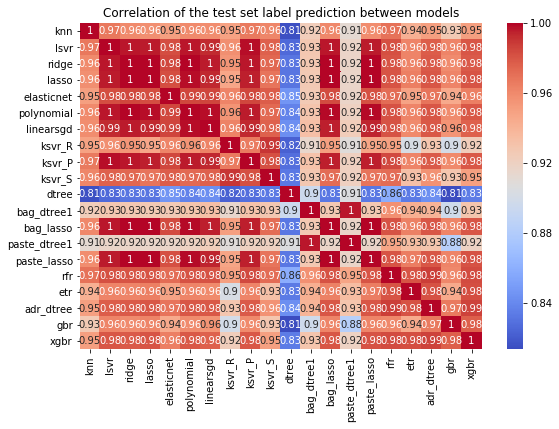

In [58]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [59]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

In [60]:
print("Top least Correlations")
print(get_top_abs_correlations(pred, 5))

Top least Correlations
dtree   gbr      0.813337
knn     dtree    0.814900
ksvr_R  dtree    0.822717
lsvr    dtree    0.826213
ksvr_P  dtree    0.828280
dtype: float64


# Stacking

In [61]:
xgbr_grid.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=2,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [90]:
# Voting top 5
from sklearn.ensemble import VotingRegressor

vrlf1 = VotingRegressor(estimators=
                              [('xgbr', xgbr_grid.best_estimator_), 
                               ('bag_lasso', bag_lasso_grid.best_estimator_), 
                               ('paste_lasso', paste_lasso_grid.best_estimator_),
                               ('ridge', grid_ridge.best_estimator_),
                               ('lasso', grid_lasso.best_estimator_),
                              ])
vrlf1_param = {
              'weights' : [[1,2,1.5,1,1], [1,1,2,1.5,1], [1,1,1,2,1.5], [1.5,1,1,1,2], [2,1.5,1,1,1]],
             }
vrlf1_grid = GridSearchCV(vrlf1, vrlf1_param,cv=5, return_train_score=True, )
vrlf1_grid.fit(X_train,y_train)

y_pred = vrlf1_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {vrlf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {vrlf1_grid.best_params_}')
print(f'Train score is {vrlf1_grid.score(X_train,y_train)}')
print(f'Test score is {vrlf1_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8981002526147268
Best Mean Cross Validation Score is {'weights': [2, 1.5, 1, 1, 1]}
Train score is 0.9431058769147848
Test score is 0.8851466346553082
r2_score:  0.8851466346553082


In [93]:
# Voting Least Correlated
vrlf2 = VotingRegressor(estimators=
                              [('dtree', grid_dtree.best_estimator_),
                               ('knn', grid_knn.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_),
                              ], )
vrlf2_param = {
              'weights':[[1,2,3],[2,1,3],[3,2,1]],
             }
vrlf2_grid = GridSearchCV(vrlf2, vrlf2_param,cv=5, return_train_score=True, )
vrlf2_grid.fit(X_train,y_train)

y_pred = vrlf2_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {vrlf2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {vrlf2_grid.best_params_}')
print(f'Train score is {vrlf2_grid.score(X_train,y_train)}')
print(f'Test score is {vrlf2_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8767547186099472
Best Mean Cross Validation Score is {'weights': [1, 2, 3]}
Train score is 0.9827366119829046
Test score is 0.8733832196309466
r2_score:  0.8733832196309466


In [71]:
# Stacking top 5
from sklearn.ensemble import StackingRegressor
srlf1 = StackingRegressor(estimators=
                              [('xgbr', xgbr_grid.best_estimator_), 
                               ('bag_lasso', bag_lasso_grid.best_estimator_), 
                               ('paste_lasso', paste_lasso_grid.best_estimator_),
                               ('ridge', grid_ridge.best_estimator_),
                               ('lasso', grid_lasso.best_estimator_)
                              ], final_estimator=XGBRegressor(random_state=42,early_stopping_rounds=2))
srlf1_param = {
              'final_estimator__C' : [0.1,0.2],
             }
srlf1_grid = GridSearchCV(srlf1, srlf1_param,cv=5, return_train_score=True, )
srlf1_grid.fit(X_train,y_train)

y_pred = srlf1_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {srlf1_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {srlf1_grid.best_params_}')
print(f'Train score is {srlf1_grid.score(X_train,y_train)}')
print(f'Test score is {srlf1_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.878043518790459
Best Mean Cross Validation Score is {'final_estimator__C': 0.1}
Train score is 0.9431579647446914
Test score is 0.8652043398080183
r2_score:  0.8652043398080183


In [72]:
# Stacking Least Correlated
srlf2 = StackingRegressor(estimators=
                              [('dtree', grid_dtree.best_estimator_),
                               ('knn', grid_knn.best_estimator_), 
                               ('gbr', gbr_grid.best_estimator_), 
                                                             ], 
                           final_estimator=
                           XGBRegressor(random_state=42,early_stopping_rounds=2))
srlf2_param = {
              'final_estimator__max_depth' : [2,6],
              'final_estimator__n_estimators' : [50,150],
              'final_estimator__learning_rate' : [0.1,0.6,0.8],
              'final_estimator__min_child_weight' : [1,3,7],
              'final_estimator__subsample':[0.6,0.9,1],
             }
srlf2_grid = GridSearchCV(srlf2, srlf2_param,cv=5, return_train_score=True, )
srlf2_grid.fit(X_train,y_train)

y_pred = srlf2_grid.predict(X_test)

print(f'Best Mean Cross Validation Score is {srlf2_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {srlf2_grid.best_params_}')
print(f'Train score is {srlf2_grid.score(X_train,y_train)}')
print(f'Test score is {srlf2_grid.score(X_test,y_test)}')
print('r2_score: ', r2_score(y_test,y_pred))

Best Mean Cross Validation Score is 0.8712330028119567
Best Mean Cross Validation Score is {'final_estimator__learning_rate': 0.1, 'final_estimator__max_depth': 2, 'final_estimator__min_child_weight': 7, 'final_estimator__n_estimators': 50, 'final_estimator__subsample': 0.6}
Train score is 0.9712463399874721
Test score is 0.8463499552765346
r2_score:  0.8463499552765346
